# Machine Bottleneck

This notebook demonstrates the formulation and solution of the a machine bottleneck problem using Pyomo/GLPK. The task is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

* [Example](#Example)
* [Modeling](#Modeling)
* [Pyomo Model](#Pyomo)
* [Visualization](#Visualization)
* [Multiple Machines](#Multiple)

<a id="Example"></a>
## Example

The problem is to schedule a sequence of jobs for a single machine. The data consists of a list of jobs. For each job, the data provides the time at which the job is released to the for machine processing, the expected duration of the job, and the due date. The problem is to sequence the jobs on the machine to meet the due dates, or show that no such sequence is possible.

The following data was presented in the Machine Bottleneck Example from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000. 

In [2]:
JOBS = {
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}

import pandas as pd
from IPython.display import display
display(pd.DataFrame(JOBS))

,A,B,C,D,E,F,G
due,10,21,15,10,5,15,22
duration,5,6,8,4,2,3,2
release,2,5,4,0,0,8,9


In [6]:
from pyomo.environ import *
from IPython.display import display
import pandas as pd

def schedule(JOBS):
    
    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    J = list(JOBS.keys())

    # decision variables
    m.start      = Var(J, domain=NonNegativeReals)
    m.pastdue    = Var(J, domain=NonNegativeReals)
    m.early      = Var(J, domain=NonNegativeReals)
    m.y = Var(J, J, domain=Binary)

    
    m.obj = Objective(expr = sum(m.pastdue[j] for j in J))
    
    m.cons = ConstraintList()
    for j in J:
        m.cons.add(m.start[j] >= JOBS[j]['release'])
                   
    solver = SolverFactory('glpk')
    solver.solve(m)
    
    for j in J:
        print(j, m.start[j]())
    
schedule(JOBS)
 

A 2.0
B 5.0
C 4.0
D 0.0
E 0.0
F 8.0
G 9.0


<a id="Modeling"></a>
## Modeling

### Data 

The data for this problem consists of a list of jobs. Each job is tagged with a unique ID along with numerical data giving the time at which the job will be released for machine processing, the expected duration, and the time at which it is due.

| Symbol | Description 
| ------ | :---------- 
| $\text{ID}_{j}$       | Unique ID for task $j$ 
| $\text{due}_{j}$      | Due time for task $j$ 
| $\text{duration}_{j}$ | Duration of task $j$ 
| $\text{release}_{j}$  | Time task $j$ becomes available for processing 

### Decision Variables

For a single machine, the essential decision variable is the start time at which the job begins processing.

| Symbol | Description |
| ------ | :---------- |
| $\text{start}_{j}$ | Start of task $j$
| $\text{makespan}$ | Time to complete *all* jobs.
| $\text{pastdue}_{j}$ | Time by which task $j$ is past due
| $\text{early}_{j}$ | Time by which task $j$ is finished early

A job cannot start until it is released for processing
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}

Once released for processing, we assume the processing continues until the job is finished. The finish time is compared to the due time, and the result stored in either the early or pastdue decision variables. These decision variables are needed to handle cases where it might not be possible to complete all jobs by the time they are due.

\begin{align*}
\text{start}_{j} + \text{duration}_{j} + \text{early}_{j} & = \text{due}_{j} + \text{pastdue}_{j}\\
\text{early}_{j} & \geq 0 \\
\text{pastdue}_{j} & \geq 0
\end{align*}

Finally, we include a single decision variable measuring the overall makespan for all jobs.
\begin{align*}
\text{start}_{j} +\text{duration}_{j} \leq \text{makespan}
\end{align*}

The final set of constraints requires that, for any given pair of jobs $j$ and $k$, that either $j$ starts before $k$ finishes, or $k$ finishes before $j$ starts. The boolean variable $y_{jk} = 1$ indicates $j$ finishes before $k$ starts, and is 0 for the opposing case. Note that we only need to consider cases $j > k$

\begin{align*}
\text{start}_{i}+\text{duration}_{i} & \leq \text{start}_{j}+My_{i,j}\\
\text{start}_{j}+\text{duration}_{j} & \leq \text{start}_{i}+M(1-y_{i,j})
\end{align*}

where $M$ is a sufficiently large enough to assure the relaxed constraint is satisfied for all plausible values of the decision variables.


<a id="Pyomo"></a>
## Pyomo Model

In [7]:
from pyomo.environ import *
from IPython.display import display
import pandas as pd

def schedule(JOBS):
    
    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    J = list(JOBS.keys())

    # decision variables
    m.start      = Var(J, domain=NonNegativeReals)
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(J, domain=NonNegativeReals)
    m.early      = Var(J, domain=NonNegativeReals)
    
    # additional decision variables for use in the objecive
    m.ispastdue  = Var(J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # for modeling disjunctive constraints
    m.y = Var(J, J, domain=Binary)
    BigM = 1000  #  max([JOBS[j]['release'] for j in J]) + sum([JOBS[j]['duration'] for j in J])

    m.OBJ = Objective(
        expr = sum([m.pastdue[j] for j in J]),
        sense = minimize
    )

    m.cons = ConstraintList()
    for j in J:
        m.cons.add(m.start[j] >= JOBS[j]['release'])
        m.cons.add(m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
        m.cons.add(m.pastdue[j] <= m.maxpastdue)
        m.cons.add(m.start[j] + JOBS[j]['duration'] <= m.makespan)
        m.cons.add(m.pastdue[j] <= BigM*m.ispastdue[j])
        for k in J:
            if j < k:
                m.cons.add(m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(1-m.y[j,k]))
                m.cons.add(m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*(m.y[j,k]))
    
    SolverFactory('glpk').solve(m)

    for j in J:
        JOBS[j]['start'] = m.start[j]()
        JOBS[j]['finish'] = m.start[j]() + JOBS[j]['duration']
        JOBS[j]['pastdue'] = m.pastdue[j]()
        JOBS[j]['early'] = m.early[j]()
        JOBS[j]['ispastdue'] = m.ispastdue[j]()
        
    # display table of results
    df = pd.DataFrame(JOBS)
    df['Total'] = df.sum(axis=1)
    df.loc[['due','finish','release','start'],'Total'] = ''
    display(df)
        
    return JOBS

JOBS = schedule(JOBS)

,A,B,C,D,E,F,G,Total
due,10.0,21.0,15.0,10.0,5.0,15.0,22.0,
duration,5.0,6.0,8.0,4.0,2.0,3.0,2.0,30
early,0.0,1.0,0.0,4.0,3.0,1.0,0.0,9
finish,11.0,20.0,30.0,6.0,2.0,14.0,22.0,
ispastdue,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2
pastdue,1.0,0.0,15.0,0.0,0.0,0.0,0.0,16
release,2.0,5.0,4.0,0.0,0.0,8.0,9.0,
start,6.0,14.0,22.0,2.0,0.0,11.0,20.0,


<a id="Visualization"></a>
## Visualization

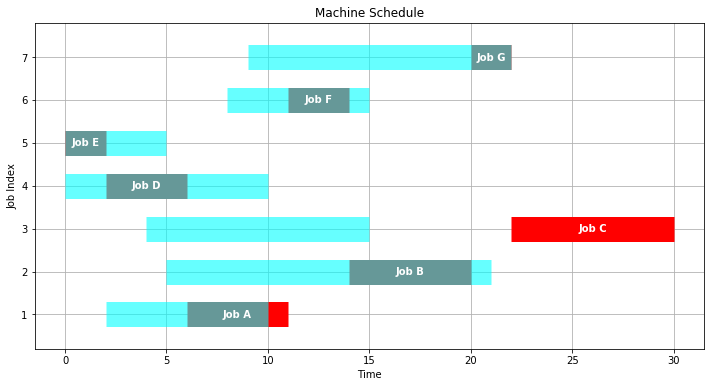

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(JOBS):
    plt.figure(figsize=(12,6))
    idx = 0
    for j in sorted(JOBS.keys()):
        idx += 1
        plt.plot([JOBS[j]['start'],JOBS[j]['finish']],[idx,idx],
             color='red',alpha=1.0,lw=25,solid_capstyle="butt")
        plt.plot([JOBS[j]['release'],JOBS[j]['due']],[idx,idx],
             color='cyan',alpha=0.6,lw=25,solid_capstyle="butt")
        plt.text((JOBS[j]['start'] + JOBS[j]['finish'])/2.0,idx,
            'Job ' + j, color='white', weight='bold',
            horizontalalignment='center', verticalalignment='center')

    plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)
    plt.title('Machine Schedule')
    plt.xlabel('Time')
    plt.ylabel('Job Index')
    plt.grid()

visualize(JOBS)

<a id="Multiple"></a>
## Multiple Machines

The case of multiple machines requires a modest extension of model described above. Given a set $M$ of machines, we introduce an additional decision binary variable $z_{j,m}$ indicating if job $j$ has been assigned to machine $m$. The additional constraints

\begin{align*}
\sum_{m\in M}z_{j,m} = 1
\end{align*}

require each job to be assigned to exactly one machine for processing.  

If both jobs $j$ and $k$ have been assigned to machine $m$, then the disjunctive ordering constraints must apply.  This logic is equivalent to the following constraints for $j < k$.

\begin{align*}
\text{start}_{i}+\text{duration}_{i} & \leq \text{start}_{j}+My_{i,j} + M(1-z_{j,m}) + M(1-z_{k,m})\\
\text{start}_{j}+\text{duration}_{j} & \leq \text{start}_{i}+M(1-y_{i,j} + M(1-z_{j,m}) + M(1-z_{k,m}))
\end{align*}

In [4]:
MACHINES = ['A','B']

In [5]:
from pyomo.environ import *
from IPython.display import display
import pandas as pd

def schedule_machines(JOBS,MACHINES):
    
    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    J = list(JOBS.keys())
    M = list(MACHINES)

    # decision variables
    m.start      = Var(J, domain=NonNegativeReals)
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(J, domain=NonNegativeReals)
    m.early      = Var(J, domain=NonNegativeReals)
    
    # additional decision variables for use in the objecive
    m.ispastdue  = Var(J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)
    
    # for binary assignment of jobs to machines
    m.z = Var(J, M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(J, J, domain=Binary)
    BigM = max([JOBS[j]['release'] for j in J]) + sum([JOBS[j]['duration'] for j in J])

    m.OBJ = Objective(
        expr = 
            + 1*sum(m.pastdue[j] for j in J)
            + 1*m.makespan
            - 1*sum(m.early[j] for j in J),
        sense = minimize
    )

    m.cons = ConstraintList()
    for j in J:
        m.cons.add(m.start[j] >= JOBS[j]['release'])
        m.cons.add(m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
        m.cons.add(m.pastdue[j] <= m.maxpastdue)
        m.cons.add(m.start[j] + JOBS[j]['duration'] <= m.makespan)
        m.cons.add(m.pastdue[j] <= BigM*m.ispastdue[j])
        m.cons.add(sum([m.z[j,mach] for mach in M]) == 1)
        for mach in M:
            for k in J:
                if j < k:
                    m.cons.add(m.start[j] + JOBS[j]['duration'] 
                        <= m.start[k] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))
                    m.cons.add(m.start[k] + JOBS[k]['duration'] 
                        <= m.start[j] + BigM*((m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    
    SolverFactory('glpk').solve(m)

    for j in J:
        JOBS[j]['start'] = m.start[j]()
        JOBS[j]['finish'] = m.start[j]() + JOBS[j]['duration']
        JOBS[j]['pastdue'] = m.pastdue[j]()
        JOBS[j]['early'] = m.early[j]()
        JOBS[j]['ispastdue'] = m.ispastdue[j]()
        JOBS[j]['machine'] = [mach for mach in MACHINES if m.z[j,mach]][0]
        
    # display table of results
    df = pd.DataFrame(JOBS)
    df['Total'] = df.sum(axis=1)
    df.loc[['due','finish','release','start','machine'],'Total'] = ''
    print(df)
        
    return JOBS

JOBS = schedule_machines(JOBS,MACHINES)

            A   B   C   D  E   F   G Total
due        10  21  15  10  5  15  22      
duration    5   6   8   4  2   3   2    30
early       3   8   3   6  3   0   7    30
finish      7  13  12   4  2  15  15      
ispastdue   0   0   0   0  0   0   0     0
machine     B   B   A   A  B   A   B      
pastdue     0   0   0   0  0   0   0     0
release     2   5   4   0  0   8   9      
start       2   7   4   0  0  12  13      


            A   B   C   D  E   F   G Total
due        10  21  15  10  5  15  22      
duration    5   6   8   4  2   3   2    30
early       3  10   3   6  3   4   9    38
finish      7  11  12   4  2  11  13      
ispastdue   0   0   0   0  0   0   0     0
machine     3   2   1   1  2   3   2      
pastdue     0   0   0   0  0   0   0     0
release     2   5   4   0  0   8   9      
start       2   5   4   0  0   8  11      


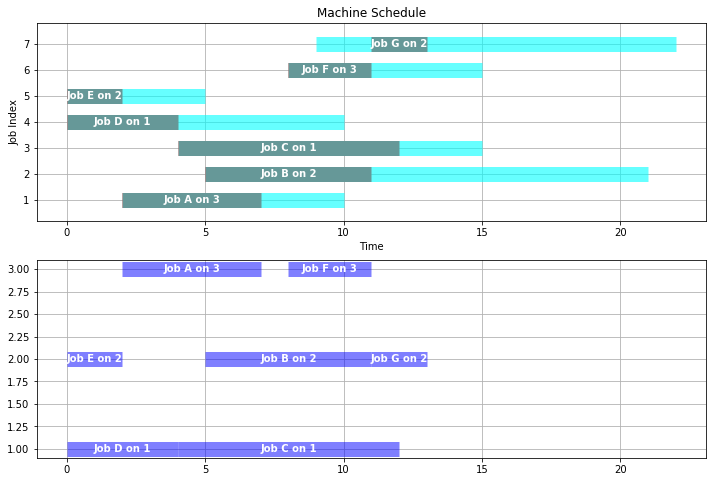

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_machines(JOBS,MACHINES):
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    idx = 0
    for j in sorted(JOBS.keys()):
        idx += 1
        plt.plot([JOBS[j]['start'],JOBS[j]['finish']],[idx,idx],
             color='red',alpha=1.0,lw=15,solid_capstyle="butt")
        plt.plot([JOBS[j]['release'],JOBS[j]['due']],[idx,idx],
             color='cyan',alpha=0.6,lw=15,solid_capstyle="butt")
        txt = 'Job '+j+' on '+JOBS[j]['machine']
        plt.text((JOBS[j]['start'] + JOBS[j]['finish'])/2.0,idx,
            txt, color='white', weight='bold',
            horizontalalignment='center', verticalalignment='center')

    plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)
    xmin,xmax = plt.xlim()
    plt.title('Machine Schedule')
    plt.xlabel('Time')
    plt.ylabel('Job Index')
    plt.grid()
    
    plt.subplot(2,1,2)
    idx = 0
    for m in sorted(MACHINES):
        idx += 1
        color = 'blue'
        for j in sorted(JOBS.keys()):
            if m == JOBS[j]['machine']:
                plt.plot([JOBS[j]['start'],JOBS[j]['finish']],[idx,idx],
                        color=color,alpha=0.5,lw=15,solid_capstyle="butt")
                txt = 'Job '+j+' on '+JOBS[j]['machine']
                plt.text((JOBS[j]['start'] + JOBS[j]['finish'])/2.0,idx,
                    txt, color='white', weight='bold',
                    horizontalalignment='center', verticalalignment='center')
    plt.xlim(xmin,xmax)
    plt.grid()  

MACHINES = ['1','2','3']
JOBS = schedule_machines(JOBS,MACHINES)
visualize_machines(JOBS,MACHINES)